# DTSA 5509 Final Project

## Problem

In the machinery industry, machines and equipment are suffered from nearly constant vibrations which generate wear on materials. Unexpected machine breakdown can cause heavy losses in revenue and fatal safety hazard in a factory. A lack of maintenance will speed up this process. In this study, we will explore the application of Support Vector Machine on a binary classification problem to predict the machine failure of a milling machine. The dataset we will be using for training and evaluating the model has 13 features and 10,000 records. Each record stores the information of the milling machine of when a unique product is produced as well as the product quality. The target label is named "Machine failure" where 0 means success and 1 represents machine failure. The raw data is a part of "Explainable Artificial Intelligence for Predictive Maintenance Applications" and gathered from Kaggle through the following link: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020/data

#### Citation

S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

## Import library

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
from scipy.stats import uniform

## Data Cleansing

In this section, I will explore the dataset and prepare the data for training the SVM models.

In [3]:
path = './data'
machine_failure = pd.read_csv(path + '/ai4i2020.csv')
machine_failure.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551.0,42.8,0.0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408.0,46.3,3.0,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498.0,49.4,5.0,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433.0,39.5,7.0,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408.0,40.0,9.0,0,0,0,0,0,0


In [4]:
machine_failure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      9999 non-null   float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   9996 non-null   float64
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          9999 non-null   float64
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(5), int64(7)

The information table shows that 5 columns have a float data type, 2 columns have object data type and remaining 7 columns are integers. First, let's drop the five columns that represent failure modes since the aim of this study is to predict the machine failure instead of forecasting failure reasons. Besides, the important message conveyed by "Product ID" has already been stored in another column named "Type" and "UDI" is just an unique identifier. We can drop them as well.

In [5]:
col_to_drop = ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
machine_failure_c = machine_failure.drop(col_to_drop, axis = 1)
machine_failure_c.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551.0,42.8,0.0,0
1,L,298.2,308.7,1408.0,46.3,3.0,0
2,L,298.1,308.5,1498.0,49.4,5.0,0
3,L,298.2,308.6,1433.0,39.5,7.0,0
4,L,298.2,308.7,1408.0,40.0,9.0,0


The columns are dropped as expected. Now, I will rename the columns with simpler ones that are easiler to work with.

In [6]:
new_col_names = {'UDI':'udi', 'Type':'product_quality', 'Air temperature [K]':'air_temp', \
                 'Process temperature [K]':'process_temp', 'Rotational speed [rpm]':'rotate_speed', 'Torque [Nm]':'torque',\
                 'Tool wear [min]':'tool_wear', 'Machine failure':'mach_failure'}
machine_failure_c = machine_failure_c.rename(columns = new_col_names)
machine_failure_c.head()

,product_quality,air_temp,process_temp,rotate_speed,torque,tool_wear,mach_failure
0,M,298.1,308.6,1551.0,42.8,0.0,0
1,L,298.2,308.7,1408.0,46.3,3.0,0
2,L,298.1,308.5,1498.0,49.4,5.0,0
3,L,298.2,308.6,1433.0,39.5,7.0,0
4,L,298.2,308.7,1408.0,40.0,9.0,0


Next, I will inspect which columns contain missing or undefined values and remove them accordingly.

In [7]:
machine_failure_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_quality  10000 non-null  object 
 1   air_temp         9999 non-null   float64
 2   process_temp     10000 non-null  float64
 3   rotate_speed     9996 non-null   float64
 4   torque           10000 non-null  float64
 5   tool_wear        9999 non-null   float64
 6   mach_failure     10000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 547.0+ KB


In [8]:
machine_failure_c.shape[0] - machine_failure_c.dropna().shape[0]

5

The information table shows that there exists null values of air temperature, rotational speed and tool wear. Besides, 5 out of 10,000 rows contains null value of at least one feature. Here, I will delete those rows since the percentage of rows that contains null values is considerably low.

In [9]:
machine_failure_c = machine_failure_c.dropna()
machine_failure_c.isnull().sum()

product_quality    0
air_temp           0
process_temp       0
rotate_speed       0
torque             0
tool_wear          0
mach_failure       0
dtype: int64

We can also find that the variable types of all columns matched with the corresponding data types from the information table. One important thing we need to be aware of is that product_quality has an object type and it is clearly an ordinal variable. It is necessary to encode it before fitting the SVM model.

In [10]:
machine_failure_c.product_quality.unique()

array(['M', 'L', 'H'], dtype=object)

In [11]:
ordinal_encode_mapper = {'L':0, 'M':1, 'H':2}
machine_failure_c.replace(ordinal_encode_mapper, inplace = True)
machine_failure_c.head()

,product_quality,air_temp,process_temp,rotate_speed,torque,tool_wear,mach_failure
0,1,298.1,308.6,1551.0,42.8,0.0,0
1,0,298.2,308.7,1408.0,46.3,3.0,0
2,0,298.1,308.5,1498.0,49.4,5.0,0
3,0,298.2,308.6,1433.0,39.5,7.0,0
4,0,298.2,308.7,1408.0,40.0,9.0,0


In the next step, I will inspect the existance of duplicated records in our data and delete them accordingly.

In [12]:
# check duplicates
machine_failure_c[machine_failure_c.duplicated()]

,product_quality,air_temp,process_temp,rotate_speed,torque,tool_wear,mach_failure
9999,0,301.7,310.6,1471.0,43.8,80.0,0


Product 3563 is duplicated in our data. Let's delete this row to prevent it for adding bias to our model. 

In [13]:
# remove duplicates
machine_failure_c.drop_duplicates(inplace = True)
machine_failure_c[machine_failure_c.duplicated()]

,product_quality,air_temp,process_temp,rotate_speed,torque,tool_wear,mach_failure


It is also very important to learn if our data is imbalanced. 

In [14]:
# check imbalance
print('0:', machine_failure_c[machine_failure_c['mach_failure'] == 0].shape[0])
print('1:', machine_failure_c[machine_failure_c['mach_failure'] == 1].shape[0])

0: 9655
1: 339


Apparently, success cases outbalanced the failure cases in our dataset. Let's keep this in mind and apply useful techniques to handle the imbalanced data in later steps. Before we split the dataset into training set and test set, it is also important to learn the correlation between features.

The data set is more cleaned after dropping irrelavent fields, renaming columns, deleting rows with null values, deleting duplicated records and encoding ordinal variables. It has also been found that the data set is highly imbalanced. We should keep this in mind and handle it later, otherwise, it can introduce bias to our models. In the next section, I will explore the correlation between features and the outliers. The SVM model is robust to outliers and it is not a necessity to remove them.

## Exploratory Data Analysis

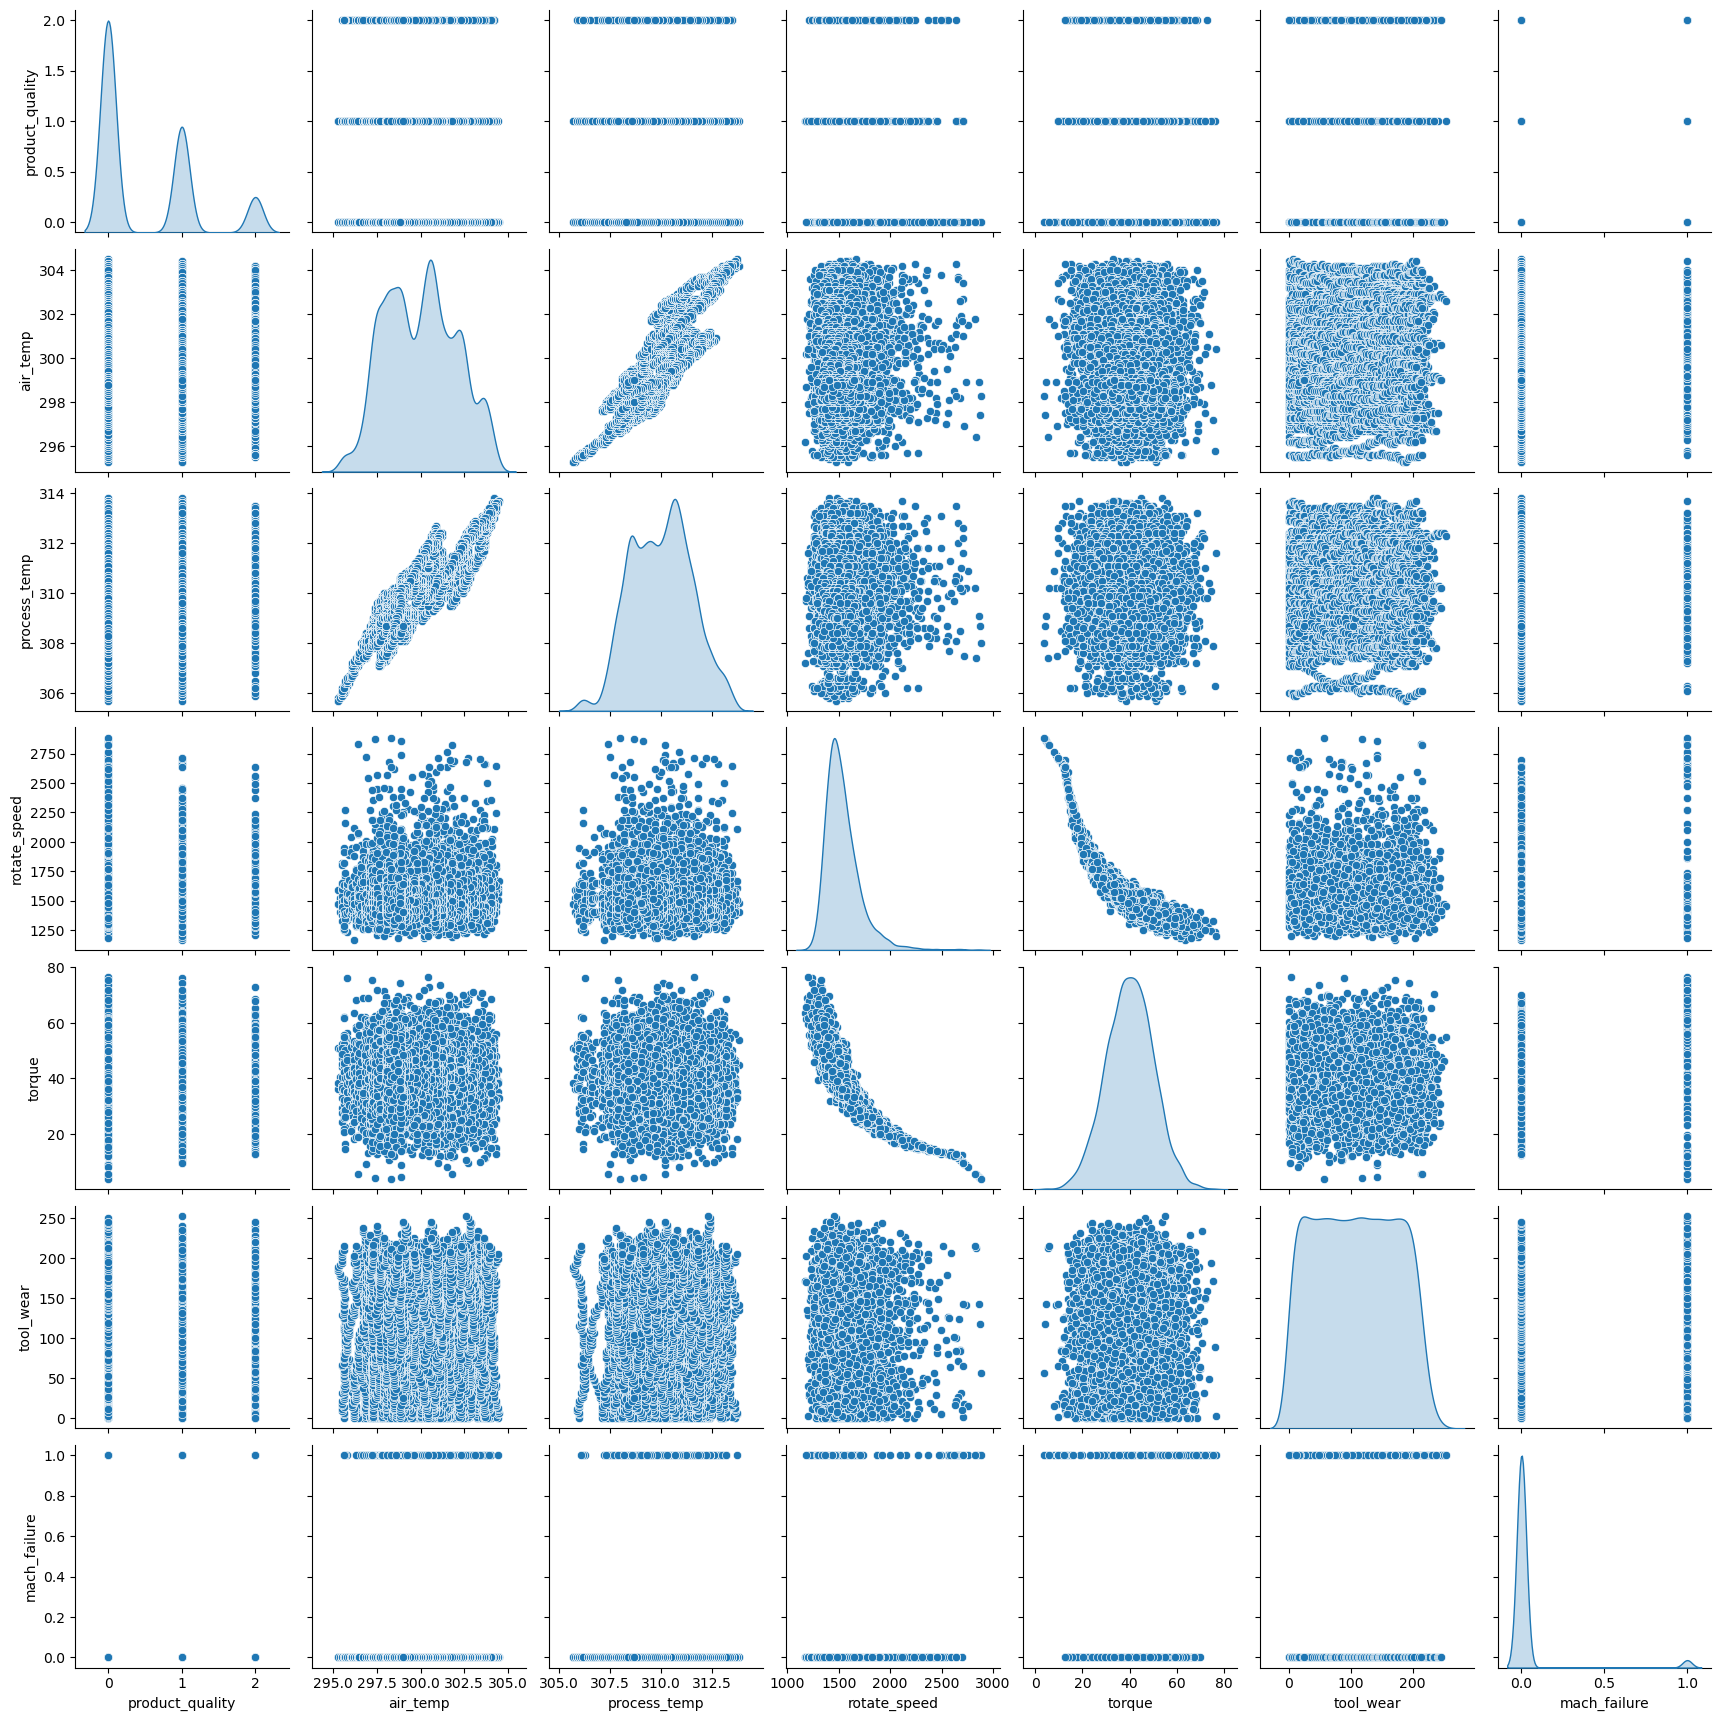

In [15]:
sns.pairplot(machine_failure_c, diag_kind = 'kde')

The pair plot illustrates that there exists some relationship between process temperature and air temperature, and torque and rotational speed as well. In fact, process temperature is positively correlated with air temperature, and torque and rotational speed are inversely proportional to each other. That means, including all above four features will introduce redundant information. The training computational complexity of SVM highly depends on number of records and the data dimensionalities. It is crucial to remove air temperature and torque for the improvement of training efficiency. A simpler model is always a better solution.

In [16]:
#machine_failure_c = machine_failure_c.drop(['air_temp', 'torque'], axis = 1)
machine_failure_c = machine_failure_c.drop(['air_temp', 'torque'], axis = 1)
machine_failure_c.head()

,product_quality,process_temp,rotate_speed,tool_wear,mach_failure
0,1,308.6,1551.0,0.0,0
1,0,308.7,1408.0,3.0,0
2,0,308.5,1498.0,5.0,0
3,0,308.6,1433.0,7.0,0
4,0,308.7,1408.0,9.0,0


Here, I plotted the histogram of the four features and the label. 

array([[<Axes: title={'center': 'product_quality'}>,
        <Axes: title={'center': 'process_temp'}>],
       [<Axes: title={'center': 'rotate_speed'}>,
        <Axes: title={'center': 'tool_wear'}>],
       [<Axes: title={'center': 'mach_failure'}>, <Axes: >]], dtype=object)

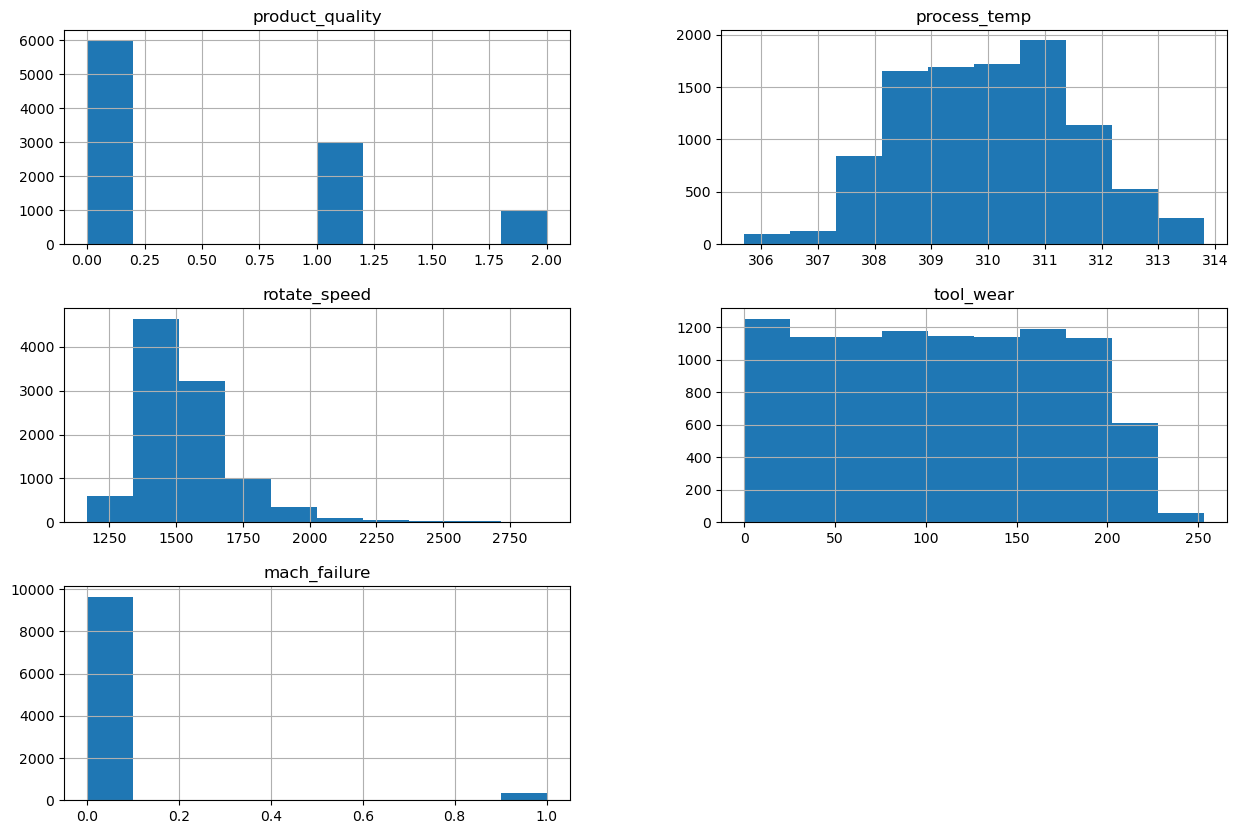

In [17]:
machine_failure_c.hist(figsize = (15,10))

According to the above histogram, we can find that rotational speed has some outliers. The SVM model is robust to the outliers so it's unnecessarily to further clean the data. In addition, the distribution of the features are either skewed or not normal. This information will be useful for feature scaling. Now, we have finished the exploratory data analysis and we can start splitting our dataset.

In this section, I have removed the redundant information and keep the columns that are easier to interpret. Outliers are found in rotational speed values but there is no need to handle this due to the property of SVM model. There are still four features in the data set, which may create difficulties on model training and hyperparameter tuning due to the the limitation on hardware (e.g. long running time). Advanced techniques may need to be applied to address this issue, e.g. feature scaling and ensembling. 

## Fitting SVM Model

In [18]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(machine_failure_c.drop('mach_failure', axis = 1), \
                                                    machine_failure_c['mach_failure'], test_size = 0.3, 
                                                    stratify = machine_failure_c['mach_failure'], random_state = 42)
print('train_size:', X_train.shape, 'test_size:', X_test.shape)

train_size: (6995, 4) test_size: (2999, 4)


In [19]:
print('train 0:', y_train[y_train == 0].shape[0])
print('train 1:', y_train[y_train == 1].shape[0])
print('test 0:', y_test[y_test == 0].shape[0])
print('test 1:', y_test[y_test== 1].shape[0])

train 0: 6758
train 1: 237
test 0: 2897
test 1: 102


Here, I split the dataset in a stratified fashion to handle the imbalanced class distributions. That means, the proportion of machine failure cases will be the same between the training set and test set. Additionally, 70% of the records will be used for training the SVM model and the remaining 30% will be used for model evaluation. During our earlier exploration, we also find that the features have significantly different scales, e.g. rotational speed vs tool wear. SVM generate the decision boundary based on kernel metrics but the feature that has the largest range (rotational speed in our study) will dominate other features on the computation of the kernel metric. Thus, it is crucial to perform feature scaling before fitting the model. Here, I scaled the numerical variables with the min-max scaler instead of standard scaler since they are either following a skewed or non-normal distribution.

In [20]:
# feature scaling
# Use MinMaxScaler() since the distribution of our feature is not normal
col_trans = ColumnTransformer([('product_quality', 'passthrough', ['product_quality']),
                               ('process_temp', MinMaxScaler(), ['process_temp']),
                               ('rotate_speed', MinMaxScaler(), ['rotate_speed']),
                               ('tool_wear', MinMaxScaler(), ['tool_wear'])],
                              remainder = 'drop')

X_train = pd.DataFrame(col_trans.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(col_trans.transform(X_test), columns = X_test.columns)

X_train.head()

,product_quality,process_temp,rotate_speed,tool_wear
0,0.0,0.506173,0.197905,0.272727
1,0.0,0.469136,0.258440,0.490119
2,0.0,0.641975,0.292782,0.671937
3,1.0,0.728395,0.045402,0.652174
4,2.0,0.580247,0.116997,0.411067


In [21]:
X_test.head()

,product_quality,process_temp,rotate_speed,tool_wear
0,1.0,0.296296,0.136787,0.584980
1,0.0,0.666667,0.185681,0.640316
2,2.0,0.493827,0.193248,0.442688
3,0.0,0.777778,0.222352,0.019763
4,0.0,0.604938,0.151921,0.075099


Next, I will fit the model with linear, polynomial and radial basis function kernel and tune hyperparameters. First, let's explore the model performance with different choices of kernels and hyperparameters. Here, I oversample the minority class and undersample the majority class in the training set to rebalance the class distribution and address the problem of imbalanced classes. I then fit models with different combinations of hyperparameters and kernels and evaluate them based on stratified 3-fold cross validation. The purpose of this step is to get basic understanding on how each model performs. Hyperparameter optimization process will be implemented in later steps.

In [22]:
# Resampling
oversampling = SMOTE(sampling_strategy = 0.2, random_state = 42)
undersampling = RandomUnderSampler(sampling_strategy = 0.5, random_state = 42)
pipeline = Pipeline(steps = [('over', oversampling), ('under', undersampling)])
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)
print('class 0:', y_train_res[y_train_res == 0].shape[0], '\n'
      'class 1:', y_train_res[y_train_res == 1].shape[0])

class 0: 2702 
class 1: 1351


In [23]:
# linear kernal
# cross_val_score split the data into training and validation set, so we can use it to explore the performance of models with 
# different hyperparameters and tune hyperparameters
# class_weight = 'balanced': we weigh different classes differently since our data is inbalanced.
skfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
lsvm1 = LinearSVC(C = 0.1, class_weight = 'balanced', dual = False).fit(X_train_res,y_train_res)
lsvm2 = LinearSVC(C = 1.0, class_weight = 'balanced', dual = False).fit(X_train_res,y_train_res)
lsvm3 = LinearSVC(C = 10.0, class_weight = 'balanced', dual = False).fit(X_train_res,y_train_res)
print(' lsvm1:', np.mean(cross_val_score(lsvm1, X_train, y_train, cv = skfold)), '\n',
      'lsvm2:', np.mean(cross_val_score(lsvm2, X_train, y_train, cv = skfold)), '\n',
      'lsvm3:', np.mean(cross_val_score(lsvm3, X_train, y_train, cv = skfold)))

 lsvm1: 0.6158697290772763 
 lsvm2: 0.6185859346236705 
 lsvm3: 0.6190147510902227


In [24]:
#polyniomial kernal
psvm1 = SVC(kernel = 'poly', C = 0.1, gamma = 1.0, degree = 3, class_weight = 'balanced').fit(X_train_res,y_train_res)
psvm2 = SVC(kernel = 'poly', C = 1.0, gamma = 1.0, degree = 3, class_weight = 'balanced').fit(X_train_res,y_train_res)
psvm3 = SVC(kernel = 'poly', C = 10.0, gamma = 1.0, degree = 3, class_weight = 'balanced').fit(X_train_res,y_train_res)

psvm4 = SVC(kernel = 'poly', C = 1.0, gamma = 0.1, degree = 3, class_weight = 'balanced').fit(X_train_res,y_train_res)
psvm5 = SVC(kernel = 'poly', C = 1.0, gamma = 1.0, degree = 3, class_weight = 'balanced').fit(X_train_res,y_train_res)
psvm6 = SVC(kernel = 'poly', C = 1.0, gamma = 10.0, degree = 3, class_weight = 'balanced').fit(X_train_res,y_train_res)

print(' psvm1:', np.mean(cross_val_score(psvm1, X_train, y_train, cv = skfold)), '\n',
      'psvm2:', np.mean(cross_val_score(psvm2, X_train, y_train, cv = skfold)), '\n',
      'psvm3:', np.mean(cross_val_score(psvm3, X_train, y_train, cv = skfold)), '\n',
      'psvm4:', np.mean(cross_val_score(psvm4, X_train, y_train, cv = skfold)), '\n',
      'psvm5:', np.mean(cross_val_score(psvm5, X_train, y_train, cv = skfold)), '\n',
      'psvm6:', np.mean(cross_val_score(psvm6, X_train, y_train, cv = skfold)))

 psvm1: 0.8403146469184205 
 psvm2: 0.8440304430870468 
 psvm3: 0.8337379893983666 
 psvm4: 0.1423906140887273 
 psvm5: 0.8440304430870468 
 psvm6: 0.8284485784485786


In [25]:
#rbf
rsvm1 = SVC(kernel = 'rbf', C = 0.1, gamma = 1.0, class_weight = 'balanced').fit(X_train_res,y_train_res)
rsvm2 = SVC(kernel = 'rbf', C = 1.0, gamma = 1.0, class_weight = 'balanced').fit(X_train_res,y_train_res)
rsvm3 = SVC(kernel = 'rbf', C = 10.0, gamma = 1.0,class_weight = 'balanced').fit(X_train_res,y_train_res)

rsvm4 = SVC(kernel = 'rbf', C = 1.0, gamma = 0.1, class_weight = 'balanced').fit(X_train_res,y_train_res)
rsvm5 = SVC(kernel = 'rbf', C = 1.0, gamma = 1.0, class_weight = 'balanced').fit(X_train_res,y_train_res)
rsvm6 = SVC(kernel = 'rbf', C = 1.0, gamma = 10.0,class_weight = 'balanced').fit(X_train_res,y_train_res)

print(' rsvm1:', np.mean(cross_val_score(rsvm1, X_train, y_train, cv = skfold)), '\n',
      'rsvm2:', np.mean(cross_val_score(rsvm2, X_train, y_train, cv = skfold)), '\n',
      'rsvm3:', np.mean(cross_val_score(rsvm3, X_train, y_train, cv = skfold)), '\n',
      'rsvm4:', np.mean(cross_val_score(rsvm4, X_train, y_train, cv = skfold)), '\n',
      'rsvm5:', np.mean(cross_val_score(rsvm5, X_train, y_train, cv = skfold)), '\n',
      'rsvm6:', np.mean(cross_val_score(rsvm6, X_train, y_train, cv = skfold)))

 rsvm1: 0.8295921503468673 
 rsvm2: 0.8044325874514554 
 rsvm3: 0.8197284518039235 
 rsvm4: 0.7642581935034766 
 rsvm5: 0.8044325874514554 
 rsvm6: 0.8314502323936286


Among the three kernels, linear kernel SVM has the poorest performance while polynomial and radial basis function kernel has similar performance with the same choice of hyperparameters.

In [26]:
# hyparameter selections
C_selection = np.linspace(1 / np.power(2, 5), np.power(2, 5), 20)
gamma_selection = np.linspace(1 / np.power(2, 5), np.power(2, 5), 20)

In [27]:
# pipeline
pipe_linear = Pipeline(steps = [('over', oversampling), 
                                ('under', undersampling),
                                ('model', SVC(kernel = 'linear', class_weight = 'balanced'))])

pipe_poly = Pipeline(steps = [('over', oversampling), 
                             ('under', undersampling),
                             ('model', SVC(kernel = 'poly', class_weight = 'balanced'))])

pipe_rbf = Pipeline(steps = [('over', oversampling), 
                             ('under', undersampling),
                             ('model', SVC(kernel = 'rbf', class_weight = 'balanced'))])

In [28]:
# linear kernel
start = time.time()
grid_linear1 = GridSearchCV(pipe_linear, param_grid = {'model__C': C_selection}, cv = skfold, scoring = 'f1_micro', n_jobs = -1).fit(X_train, y_train)
end = time.time()
print('running time:', end - start)
print('best_parameter', grid_linear1.best_params_)
print('best_score', grid_linear1.best_score_)

running time: 30.987703323364258
best_parameter {'model__C': 5.078947368421053}
best_score 0.6546159612197348


In [29]:
# linear kernel
start = time.time()
grid_linear2 = GridSearchCV(BaggingClassifier(pipe_linear, max_samples = 0.3, n_estimators = 10), param_grid = {'base_estimator__model__C': C_selection}, \
                            cv = skfold, scoring = 'f1_micro', n_jobs = -1).fit(X_train, y_train)
end = time.time()
print('running time:', end - start)
print('best_parameter', grid_linear2.best_params_)
print('best_score', grid_linear2.best_score_)

running time: 15.374246835708618
best_parameter {'base_estimator__model__C': 15.17434210526316}
best_score 0.743676106883654


In [30]:
# linear kernel
start = time.time()
grid_linear3 = RandomizedSearchCV(pipe_linear, param_distributions = {'model__C': C_selection}, cv = skfold, scoring = 'f1_micro', \
                            n_jobs = -1).fit(X_train, y_train)
end = time.time()
print('running time:', end - start)
print('best_parameter', grid_linear3.best_params_)
print('best_score', grid_linear3.best_score_)

running time: 11.124104261398315
best_parameter {'model__C': 8.444078947368421}
best_score 0.6540442672518144


In [31]:
# linear kernel
start = time.time()
grid_linear4 = RandomizedSearchCV(BaggingClassifier(pipe_linear, max_samples = 0.3, n_estimators = 10), \
                                  param_distributions = {'base_estimator__model__C': C_selection}, cv = skfold, scoring = 'f1_micro', \
                                  n_jobs = -1).fit(X_train, y_train)
end = time.time()
print('running time:', end - start)
print('best_parameter', grid_linear4.best_params_)
print('best_score', grid_linear4.best_score_)

running time: 13.83431100845337
best_parameter {'base_estimator__model__C': 6.761513157894737}
best_score 0.7466773929038081


It is important to take running time into consideration when applying machine learning models since faster running time gives us more flexibility to test a larger number of models and hyperparameters. That means, we will be more likely to find a model that has a more desirable performance. Here, I have tested the speed of hyperparameter tuning with grid search, random search, grid search on bagging classifier and random search on bagging classifier separately. Random search on linear kernel SVM runs faster than grid search and bagging classifier technique improves the performance score. Overall, random search on bagging classifier estimator gives the best balance between running time and performance score. Additionally, F1 score is used for hyperparameter tunning instead of accuracy score since it is more meaningful for evaluating the model performance with imbalanced class. Next, I will use this technique to find the optimized hyperparameters for radial basis function kernel SVM and polynomial kernel SVM.

In [32]:
# polynomial kernel
start = time.time()
grid_poly = RandomizedSearchCV(BaggingClassifier(pipe_rbf, max_samples = 0.3, n_estimators = 10), \
                               param_distributions = {'base_estimator__model__C': C_selection, 'base_estimator__model__gamma': gamma_selection}, \
                               cv = skfold, scoring = 'f1_micro', n_jobs = -1).fit(X_train, y_train)
end = time.time()
print('running time:', end - start)
print('best_parameter', grid_poly.best_params_)
print('best_score', grid_poly.best_score_)

running time: 10.693475484848022
best_parameter {'base_estimator__model__gamma': 20.222039473684212, 'base_estimator__model__C': 20.222039473684212}
best_score 0.927804611766876


In [33]:
# rbf kernel
start = time.time()
grid_rbf = RandomizedSearchCV(BaggingClassifier(pipe_rbf, max_samples = 0.3, n_estimators = 10), \
                              param_distributions = {'base_estimator__model__C': C_selection, 'base_estimator__model__gamma': gamma_selection}, \
                              cv = skfold, scoring = 'f1_micro', n_jobs = -1).fit(X_train, y_train)
end = time.time()
print('running time:', end - start)
print('best_parameter', grid_rbf.best_params_)
print('best_score', grid_rbf.best_score_)

running time: 13.317303657531738
best_parameter {'base_estimator__model__gamma': 30.31743421052632, 'base_estimator__model__C': 32.0}
best_score 0.9369544133695077


In [34]:
lsvm_f = grid_linear4.best_estimator_
psvm_f = grid_poly.best_estimator_
rsvm_f = grid_rbf.best_estimator_

Given the same range of hyperparameters, radial basis function kernel SVM has a much better performance evaluating on the validation set compared to linear kernel SVM, and a similar performance compared to polynomial kernel. I have fit three different SVM models with the best estimator generated. In the next section, I will evaluate their performance on the test set using multiple evaluation metrics.

## Model Evaluation

Now, I have fit three bagging classifier using SVM with different kernels as the base estimator. In this section, these classifiers will be evaluated by ROC curve (AUC), Precision-Recall curve (PRAUC) and F1 score.

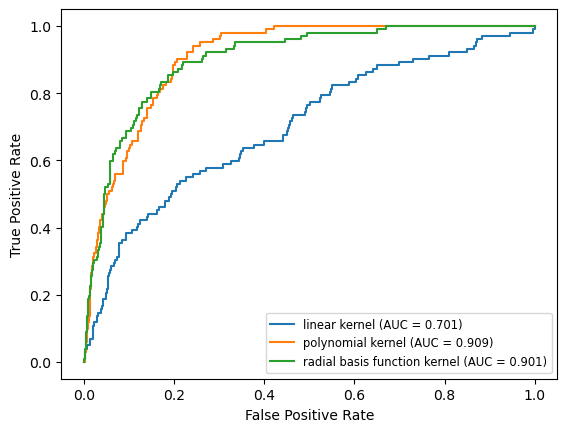

In [35]:
# ROC
ldec = lsvm_f.decision_function(X_test)
lfpr, ltpr, lthresholds = metrics.roc_curve(y_test, ldec)
lroc_auc = round(metrics.roc_auc_score(y_test, ldec), 3)
plt.plot(lfpr, ltpr, label = 'linear kernel (AUC = ' + str(lroc_auc) +')')

pdec = psvm_f.decision_function(X_test)
pfpr, ptpr, pthresholds = metrics.roc_curve(y_test, pdec)
proc_auc = round(metrics.roc_auc_score(y_test, pdec), 3)
plt.plot(pfpr, ptpr, label = 'polynomial kernel (AUC = ' + str(proc_auc) +')')

rdec = rsvm_f.decision_function(X_test)
rfpr, rtpr, rthresholds = metrics.roc_curve(y_test, rdec)
rroc_auc = round(metrics.roc_auc_score(y_test, rdec), 3)
plt.plot(rfpr, rtpr, label = 'radial basis function kernel (AUC = ' + str(rroc_auc) +')')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 0, fontsize = 'small')

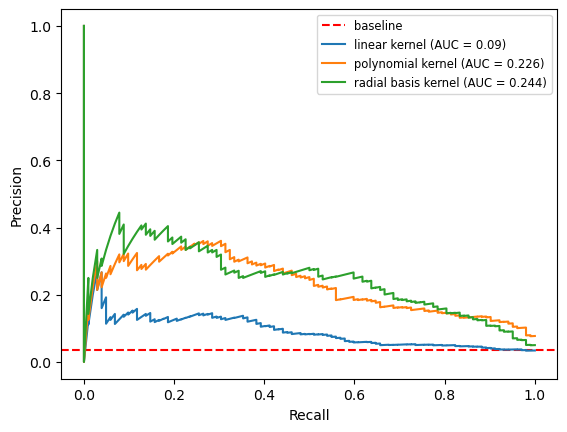

In [36]:
# Precision-recall curve
baseline = sum(y_test == 1) / y_test.shape[0] 
plt.axhline(baseline, linestyle = '--', label = 'baseline', color = 'r')

lprecision, lrecall, lthresholds = metrics.precision_recall_curve(y_test, ldec)
lpr_auc = round(metrics.auc(lrecall, lprecision),3)
plt.plot(lrecall, lprecision, label = 'linear kernel (AUC = ' + str(lpr_auc) + ')')

pprecision, precall, pthresholds = metrics.precision_recall_curve(y_test, pdec)
ppr_auc = round(metrics.auc(precall, pprecision),3)
plt.plot(precall, pprecision, label = 'polynomial kernel (AUC = ' + str(ppr_auc) + ')')

rprecision, rrecall, rthresholds = metrics.precision_recall_curve(y_test, rdec)
rpr_auc = round(metrics.auc(rrecall, rprecision),3)
plt.plot(rrecall, rprecision, label = 'radial basis kernel (AUC = ' + str(rpr_auc) + ')')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 0, fontsize = 'small')

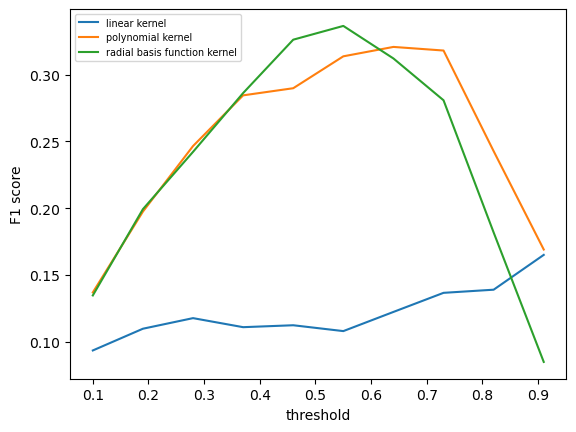

In [37]:
# F1 Score
th_list = np.linspace(0.1, 1, 10, endpoint = False)
lscore = []
pscore = []
rscore = []
for threshold in th_list:
    lpred = lsvm_f.predict_proba(X_test)[:, 1] >= threshold
    lscore.append(metrics.f1_score(y_test, lpred))
    ppred = psvm_f.predict_proba(X_test)[:, 1] >= threshold
    pscore.append(metrics.f1_score(y_test, ppred))
    rpred = rsvm_f.predict_proba(X_test)[:, 1] >= threshold
    rscore.append(metrics.f1_score(y_test, rpred))

plt.plot(th_list, lscore, label = 'linear kernel')
plt.plot(th_list, pscore, label = 'polynomial kernel')
plt.plot(th_list, rscore, label = 'radial basis function kernel')

plt.xlabel('threshold')
plt.ylabel('F1 score')

plt.legend(loc = 0, fontsize = 'x-small')

Among the three classifiers, the one using radial basis function kernel SVM performs the best based on the three evaluation metrics. All three models have acceptable performance based on ROC-AUC but they have relatively low PRAUC and F1 score among all thresholds. Considering we are more interested in predicting the minority class (machine failure) in this study, the approach of relying on precision-recall curve and PRAUC for model evaluation and comparison is more suitable since they do not make use of true negatives in the computation. F1 score is also reliable since our class distribution is imbalanced.

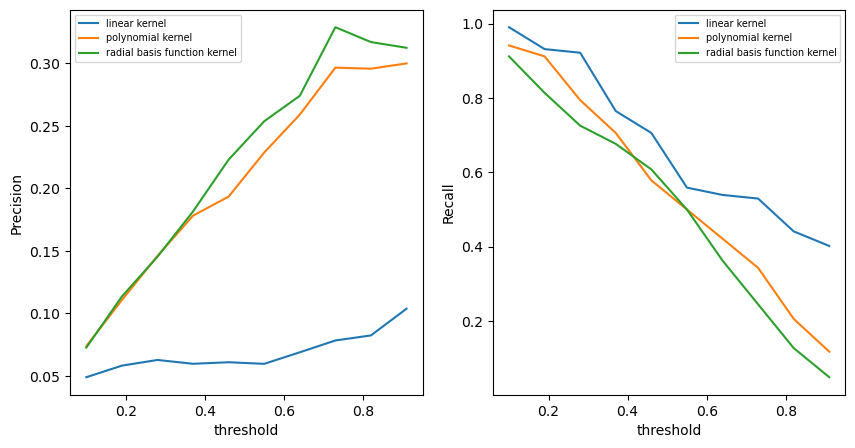

In [38]:
th_list = np.linspace(0.1, 1, 10, endpoint = False)
lscore_p = []
pscore_p = []
rscore_p = []
for threshold in th_list:
    lpred = lsvm_f.predict_proba(X_test)[:, 1] >= threshold
    lscore_p.append(metrics.precision_score(y_test, lpred))
    ppred = psvm_f.predict_proba(X_test)[:, 1] >= threshold
    pscore_p.append(metrics.precision_score(y_test, ppred))
    rpred = rsvm_f.predict_proba(X_test)[:, 1] >= threshold
    rscore_p.append(metrics.precision_score(y_test, rpred))

fig, (axs1, axs2) = plt.subplots(1, 2, figsize = (10, 5))
axs1.plot(th_list, lscore_p, label = 'linear kernel')
axs1.plot(th_list, pscore_p, label = 'polynomial kernel')
axs1.plot(th_list, rscore_p, label = 'radial basis function kernel')
axs1.set_xlabel('threshold')
axs1.set_ylabel('Precision')
axs1.legend(loc = 0, fontsize = 'x-small')


th_list = np.linspace(0.1, 1, 10, endpoint = False)
lscore_r = []
pscore_r = []
rscore_r = []
for threshold in th_list:
    lpred = lsvm_f.predict_proba(X_test)[:, 1] >= threshold
    lscore_r.append(metrics.recall_score(y_test, lpred))
    ppred = psvm_f.predict_proba(X_test)[:, 1] >= threshold
    pscore_r.append(metrics.recall_score(y_test, ppred))
    rpred = rsvm_f.predict_proba(X_test)[:, 1] >= threshold
    rscore_r.append(metrics.recall_score(y_test, rpred))

axs2.plot(th_list, lscore_r, label = 'linear kernel')
axs2.plot(th_list, pscore_r, label = 'polynomial kernel')
axs2.plot(th_list, rscore_r, label = 'radial basis function kernel')
axs2.set_xlabel('threshold')
axs2.set_ylabel('Recall')
axs2.legend(loc = 0, fontsize = 'x-small')

By plotting precision and recall score of different thresholds, we can see a clear trade-off between the two scores and this behavior is as expected. Bagging classifiers built upon linear kernel SVM has the lowest precisions overall but the highest recall at large threshold. Precision and recall scores of the bagging classifiers built upon the other two kernels are comparable among all thresholds. Overall, the three classifiers achieve a higher recall score at low threshold but the maximum precision score they can achieve is low. That means the models return a few positive cases but a low percentage of them are predicted correctly. Of course, the quality of our models can be better tested with the domain knowledge and the performance is acceptable in some scenarios even if the score is relatively low. In this study, I will try to improve the performance by tuning some other hyperparamters including class weights, number of estimators and sampling strategy.

In [39]:
def iter_process(o_ratio, u_ratio, max_samples, n_estimators, re_sample = 'b', weight = 'balanced'):
    oversampling = SMOTE(sampling_strategy = o_ratio, random_state = 42)
    undersampling = RandomUnderSampler(sampling_strategy = u_ratio, random_state = 42)
    if re_sample == 'b':
        pipe = Pipeline(steps = [('over', oversampling), 
                                 ('under', undersampling),
                                 ('model', SVC(kernel = 'rbf', class_weight = weight))])
    elif re_sample == 'o':
        pipe = Pipeline(steps = [('over', oversampling),
                                 ('model', SVC(kernel = 'rbf', class_weight = weight))]) 
    else:
        pipe = Pipeline(steps = [('under', undersampling),
                                 ('model', SVC(kernel = 'rbf', class_weight = weight))]) 
        
    grid = RandomizedSearchCV(BaggingClassifier(pipe, max_samples = max_samples, n_estimators = n_estimators), \
                              param_distributions = {'base_estimator__model__C': C_selection, 'base_estimator__model__gamma': gamma_selection}, \
                              cv = skfold, scoring = 'f1_micro', n_jobs = -1).fit(X_train, y_train)
    model = grid.best_estimator_

    dec = model.decision_function(X_test)
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, dec)
    pr_auc = round(metrics.auc(recall, precision),3)

    return model, pr_auc


In [40]:
weights = [{0:0.03, 1:1}, {0:0.03, 1:10}, {0:0.3, 1:100}, {0:0.1, 1:100}, {0:1, 1:10}, {0:1, 1:100}, {0:10, 1:100}]
for weight in weights:
    model, pr_auc = iter_process(o_ratio = 0.2, u_ratio = 0.5, max_samples = 0.3, n_estimators = 10, weight = weight)
    print(weight, pr_auc)

{0: 0.03, 1: 1} 0.206
{0: 0.03, 1: 10} 0.221
{0: 0.3, 1: 100} 0.197
{0: 0.1, 1: 100} 0.235
{0: 1, 1: 10} 0.189
{0: 1, 1: 100} 0.189
{0: 10, 1: 100} 0.217


In [41]:
n_estimators = [10, 20, 50]
for n in n_estimators:
    model, pr_auc = iter_process(o_ratio = 0.2, u_ratio = 0.5, max_samples = 0.3, n_estimators = n, weight = {0:1, 1:10})
    print(n, pr_auc)

10 0.221
20 0.208
50 0.215


In [42]:
ratio = [{'o':0.2, 'u':0.5}, {'o':0.3, 'u':0.5}, {'o':0.3, 'u':0.4}, {'o':0.1, 'u':0.6}]
for r in ratio:
    model, pr_auc = iter_process(o_ratio = r['o'], u_ratio = r['u'], max_samples = 0.3, n_estimators = n, weight = {0:1, 1:10})
    print(r, pr_auc)

{'o': 0.2, 'u': 0.5} 0.203
{'o': 0.3, 'u': 0.5} 0.217
{'o': 0.3, 'u': 0.4} 0.206
{'o': 0.1, 'u': 0.6} 0.23


PRAUC score is very stable around 0.23 after re-fitting the model with different class weights, sampling strategy and number of estimators. It could mean that the bagged classifier based on SVM estimator reaches its limit with the current settings. A problem of our test set is that the class is highly imbalanced, and it could result in a low precision score. Overall, bagging classifier based on radial basis function kernel SVM has the highest PRAUC score and F1 score among all thresholds. It will be used as the final model of this study.

## Discussion and Conclusion

This study was focused on the application of SVM on the prediction of machine failure of milling machines. Multiple SVM models are fit under different settings and evaluated to find the model optimized on the prediction of positive cases (minority class). During the exploration, I find multiple ways to improve the running time efficiency without sacrificing much performance. Before we fit any model based on SVM, we should always scale the features using some scalers since it can improve model convergence and avoid the feature with the largest range to dominate the computation of kernel functions. Beyond that, it will also significantly reduce the running time and be beneficial to us. Another technique is to use random search instead of grid search for hyperparameter optimization in the scenario when running time is not acceptable. Random search technique tests random combinations of hyperparameters in the given range instead of searching all the given hyperparameter combinations, and it has a high probability of finding the optima. If the result is not satisfied, we can always improve the performance by increase the number of trails. Bagging classifier is another technique that can not only reduce the running time by adjusting the maximum samples to train each estimator but also improve the performance compared with a single SVM model. Through a combination of random search and bagging classifier, I find the hyperparameters that are optimized on the average F1 score evaluated on the validation sets in a relatively shorter time.

As we discussed earlier, the final model has an "ok" recall score but low precision, F1 and PRAUC score in general. That means, this model is able to return a few results that are identified as machine failure but a large portion of them is actually belong to the success class. Besides, some positive cases are not captured by the final model. Several factors could potentially lead to the low prediction ability. First, the two classes in our test set is highly imbalanced. This increases the chances of false classification in the prediction of the minority class. Besides, some hyperparameters including but not limited to maximum samples, number of estimators, weights are not selected through an optimization process, e.g., random search, grid search. The final model might not be optimized on the prediction of the minority class. There are some opportunities to further improve the final model. In the future, wider range of hyperparameter selections can be given for optimization process to aim finding a model with better performance based on F1 score. Beyond that, tunning additional hyperparameters, e.g., class weights, could also be beneficial. Considering the final model has an "ok" recall score, it doesn't always mean that the model is not useful even though the precision score is low. The precision score is not so bad if testing the predicted positive cases is cheap. Besides, this model can be useful to predict probability considering the recall can reach around 0.9 at some choices of threshold. In reality, the choice of threshold varies among different industries, and this often need the advice from domain experts, but this is beyond the scope of this study.